## Загрузка данных

### Импорт используемых библиотек

In [591]:
import pandas as pd
import numpy as np
import ydata_profiling

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import phik
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.pipeline import Pipeline

from datetime import datetime
from IPython.core.display import display, HTML

pd.set_option('display.max_columns', None)

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings
warnings.filterwarnings(action='ignore')

display(HTML("<style>.container { width:80% !important; }</style>"))

In [531]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Чтение файла

In [532]:
df_orders = pd.read_feather("orders.feather")
df_lesson_course = pd.read_feather("lesson_course.feather")
df_teachers_info = pd.read_feather("teachers_info.feather")
df_teacher_prices = pd.read_feather("teacher_prices.feather")
df_teachers = pd.read_feather("teachers.feather")
df_lessons = pd.read_feather("lessons.feather")

Функция о выводе информации

In [533]:
def print_dataset_info(df):
    print(f"Информация о датасете:")
    display(df.info())
    
    print("\nПроцент пропусков:")
    missing_percent = (df.isnull().sum() / df.shape[0] * 100).reset_index()
    missing_percent.columns = ['Признак', 'Процент пропусков']
    missing_percent_styled = missing_percent.style.background_gradient(cmap='Reds', subset=['Процент пропусков'])
    display(missing_percent_styled)
    
    print("\nКоличество дубликатов:")
    display(df.duplicated().sum())
    
    print("\nПервые 5 строк датасета:")
    display(df.head())

#### df_orders

In [534]:
print_dataset_info(df_orders)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id 

None


Процент пропусков:


,Признак,Процент пропусков
0,id,0.000000
1,order_date,0.000000
2,subject_id,0.866880
3,purpose,13.970589
4,lesson_price,0.000000
5,lesson_duration,0.000000
6,lesson_place,99.997399
7,home_metro_id,46.097154
8,add_info,12.348168
9,start_date,40.800311



Количество дубликатов:


900


Первые 5 строк датасета:


,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к зая...",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.0,16,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.0,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392.0,16,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,NaN,16,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.0,NaN,None,None,1


Удалим столбцы с 50%+ пропусками + дубликаты

In [535]:
# Подсчет пропусков в каждом признаке
missing_values_count = df_orders.isnull().sum()

# Определение признаков, у которых более 50% пропусков
columns_to_drop = missing_values_count[missing_values_count / len(df_orders) > 0.5].index

# Удаление признаков
df_orders_dropped = df_orders.drop(columns_to_drop, axis=1)

In [536]:
#Удалить дубликаты
df_orders = df_orders.drop_duplicates()

In [537]:
#переведем order_date в формат datetime в формате 2020-01-01
df_orders['order_date'] = pd.to_datetime(df_orders['order_date'], errors='coerce')

In [538]:
df_orders.head()

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к зая...",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.0,16,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.0,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392.0,16,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,NaN,16,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.0,NaN,None,None,1


#### df_lesson_course

In [539]:
print_dataset_info(df_lesson_course)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893438 entries, 0 to 893437
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 893438 non-null  int64  
 1   client_id          893437 non-null  float64
 2   teacher_id         893438 non-null  int64  
 3   order_id           890132 non-null  float64
 4   lesson_place       893438 non-null  int64  
 5   lesson_price       893438 non-null  int64  
 6   is_active          893438 non-null  int64  
 7   lesson_duration    893438 non-null  int64  
 8   date_updated       893438 non-null  object 
 9   suspend_till_date  893438 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 68.2+ MB


None


Процент пропусков:


,Признак,Процент пропусков
0,id,0.000000
1,client_id,0.000112
2,teacher_id,0.000000
3,order_id,0.370031
4,lesson_place,0.000000
5,lesson_price,0.000000
6,is_active,0.000000
7,lesson_duration,0.000000
8,date_updated,0.000000
9,suspend_till_date,0.000000



Количество дубликатов:


0


Первые 5 строк датасета:


,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
0,240884,427831.0,133738,718009.0,2,1000,1,60,2021-04-25 23:08:17.883,2018-08-27 00:00:00.000
1,242243,429075.0,106838,720876.0,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000
2,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940
3,242476,428940.0,138783,721219.0,1,0,0,0,2021-06-22 20:36:53.287,2018-09-03 00:00:00.000
4,242942,424704.0,3476,720891.0,4,600,0,60,2021-12-19 13:29:29.257,2022-03-20 00:00:00.000


In [540]:
df_lesson_course['date_updated'] = pd.to_datetime(df_lesson_course['date_updated'], errors='coerce')
df_lesson_course['suspend_till_date'] = pd.to_datetime(df_lesson_course['suspend_till_date'], errors='coerce')

#### df_teachers_info

In [541]:
print_dataset_info(df_teachers_info)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       307972 non-null  int64  
 1   reg_date                 307972 non-null  object 
 2   birth_date               307972 non-null  object 
 3   teaching_start_date      307972 non-null  object 
 4   is_email_confirmed       307972 non-null  int64  
 5   lesson_duration          307972 non-null  int64  
 6   lesson_cost              307972 non-null  int64  
 7   is_display               307972 non-null  int64  
 8   last_visited             235837 non-null  object 
 9   is_pupils_needed         11208 non-null   float64
 10  is_cell_phone_confirmed  307972 non-null  int64  
 11  area_id                  307972 non-null  int64  
 12  sex                      307972 non-null  int64  
 13  orders_allowed           307972 non-

None


Процент пропусков:


,Признак,Процент пропусков
0,id,0.000000
1,reg_date,0.000000
2,birth_date,0.000000
3,teaching_start_date,0.000000
4,is_email_confirmed,0.000000
5,lesson_duration,0.000000
6,lesson_cost,0.000000
7,is_display,0.000000
8,last_visited,23.422584
9,is_pupils_needed,96.360708



Количество дубликатов:


0


Первые 5 строк датасета:


,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
0,33,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,0,60,1000,1,2022-10-24 16:48:38.410,1.0,0,1,1,0,6
1,46,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,0,60,500,0,None,1.0,0,1,3,1,0
2,51,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,0,60,1500,0,2022-09-26 09:43:56.123,1.0,0,1,2,1,0
3,52,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,0,60,1000,1,2020-04-03 15:53:50.867,0.0,0,1,2,1,2
4,54,2007-12-24 19:26:46.000,1985-09-30 00:00:00.000,2004-01-01 00:00:00.000,0,45,400,0,None,1.0,0,1,3,1,0


Удалим is_pupils_needed

In [542]:
df_teachers_info = df_teachers_info.drop(
    ['is_pupils_needed'], axis=1)

In [543]:
df_teachers_info['reg_date'] = pd.to_datetime(df_teachers_info['reg_date'], errors='coerce')
df_teachers_info['birth_date'] = pd.to_datetime(df_teachers_info['birth_date'], errors='coerce')
df_teachers_info['teaching_start_date'] = pd.to_datetime(df_teachers_info['teaching_start_date'], errors='coerce')
df_teachers_info['last_visited'] = pd.to_datetime(df_teachers_info['last_visited'], errors='coerce')

#### df_teacher_prices

In [544]:
print_dataset_info(df_teacher_prices)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432422 entries, 0 to 432421
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_update     432422 non-null  object 
 1   teacher_id      427852 non-null  float64
 2   subject_id      432422 non-null  int64  
 3   price           432422 non-null  int64  
 4   price_external  432422 non-null  int64  
 5   price_remote    432422 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.8+ MB


None


Процент пропусков:


,Признак,Процент пропусков
0,date_update,0.000000
1,teacher_id,1.056838
2,subject_id,0.000000
3,price,0.000000
4,price_external,0.000000
5,price_remote,0.000000



Количество дубликатов:


860


Первые 5 строк датасета:


,date_update,teacher_id,subject_id,price,price_external,price_remote
0,2008-01-20 19:47:18.587,300.0,2,1200,1200,1200
1,2008-01-22 00:33:39.660,125.0,13,0,0,3000
2,2008-01-22 00:33:39.660,125.0,14,0,0,3000
3,2008-01-22 00:37:01.963,91.0,8,2000,0,0
4,2008-02-08 21:27:19.177,372.0,33,400,400,400


In [545]:
df_teacher_prices['date_update'] = pd.to_datetime(df_teacher_prices['date_update'], errors='coerce')

In [546]:
df_teacher_prices = df_teacher_prices.drop_duplicates()

#### df_lessons

In [547]:
print_dataset_info(df_lessons)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191127 entries, 0 to 1191126
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   id                1191127 non-null  int32   
 1   lesson_course_id  1191127 non-null  int32   
 2   lesson_date       1191127 non-null  category
 3   time_from         1191127 non-null  category
 4   time_to           1191127 non-null  category
 5   home_task         4969 non-null     category
 6   is_regular        1191127 non-null  int8    
 7   amount_to_pay     593376 non-null   float64 
 8   amount_paid       8143 non-null     float64 
dtypes: category(4), float64(2), int32(2), int8(1)
memory usage: 37.9 MB


None


Процент пропусков:


,Признак,Процент пропусков
0,id,0.000000
1,lesson_course_id,0.000000
2,lesson_date,0.000000
3,time_from,0.000000
4,time_to,0.000000
5,home_task,99.582832
6,is_regular,0.000000
7,amount_to_pay,50.183650
8,amount_paid,99.316362



Количество дубликатов:


0


Первые 5 строк датасета:


,id,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
0,135797,347,2023-04-14 00:00:00.000,12:45:00,13:50:00,NaN,1,NaN,NaN
1,283596,185756,2022-11-15 00:00:00.000,20:30:00,21:30:00,NaN,0,NaN,NaN
2,322184,184189,2022-12-15 00:00:00.000,16:00:00,17:30:00,NaN,0,NaN,NaN
3,371621,213849,2023-02-13 00:00:00.000,19:30:00,20:30:00,NaN,0,NaN,NaN
4,375586,196475,2023-02-16 00:00:00.000,10:00:00,11:00:00,NaN,0,NaN,NaN


Удалим home_task и amount_paid

In [548]:
df_lessons = df_lessons.drop(
    ['home_task',
     'amount_paid'], axis=1)

#### df_teachers

In [549]:
print_dataset_info(df_teachers)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1656 non-null   int64  
 1   lessons_delivered         1656 non-null   float64
 2   mean_lesson_price         1656 non-null   float64
 3   lessons_given             1656 non-null   float64
 4   lessons_started_fraction  1656 non-null   float64
 5   lessons_per_pupil         1656 non-null   float64
 6   money_recieved            1656 non-null   float64
 7   blocked                   1656 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 103.6 KB


None


Процент пропусков:


,Признак,Процент пропусков
0,id,0.000000
1,lessons_delivered,0.000000
2,mean_lesson_price,0.000000
3,lessons_given,0.000000
4,lessons_started_fraction,0.000000
5,lessons_per_pupil,0.000000
6,money_recieved,0.000000
7,blocked,0.000000



Количество дубликатов:


0


Первые 5 строк датасета:


,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0


## Объединение датасетов и создание признаков

### df_teachers, df_teachers_info

Объединим df_teachers и df_teachers_info по id с левого датасета, т.к. ключевой признак размечен именно там

In [550]:
df_teachers_full = pd.merge(df_teachers, df_teachers_info, on='id', how='left')

In [551]:
df_teachers_full.shape

(1656, 21)

### df_teacher_prices

In [552]:
#Переименовать teacher_id в id в датасете df_teacher_prices
df_teacher_prices = df_teacher_prices.rename(columns={'teacher_id': 'id'})

Нужно агрегировать данные по id

Признак с датой удалим, т.к. ее сложно будем агрегировать

In [553]:
#удалить столбец с датой в датасете df_teacher_prices
df_teacher_prices = df_teacher_prices.drop(['date_update'], axis=1)

In [554]:
df_teacher_prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 431562 entries, 0 to 432421
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              426998 non-null  float64
 1   subject_id      431562 non-null  int64  
 2   price           431562 non-null  int64  
 3   price_external  431562 non-null  int64  
 4   price_remote    431562 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 19.8 MB


In [555]:
df_teacher_prices_agg = df_teacher_prices.groupby('id').agg({
    'subject_id': 'count',
    'price': ['sum', 'mean'],
    'price_external': ['sum', 'mean'],
    'price_remote': ['sum', 'mean']
}).reset_index()


In [556]:
df_teacher_prices_agg.head()

id subject_id price        price_external         price_remote  \
             count   sum   mean            sum    mean          sum   
0  33.0          1   500  500.0              0     0.0         1000   
1  46.0          1   500  500.0            500   500.0          500   
2  51.0          3     0    0.0              0     0.0         5800   
3  52.0          2     0    0.0           2000  1000.0         2000   
4  54.0          1   400  400.0            400   400.0          400   

                
          mean  
0  1000.000000  
1   500.000000  
2  1933.333333  
3  1000.000000  
4   400.000000

Преобразуем в dataframe

In [557]:
df_teacher_prices_agg.columns = ['id', 'subject_id_count', 
                             'price_sum', 'price_mean',
                             'price_external_sum', 'price_external_mean',
                             'price_remote_sum', 'price_remote_mean']


In [558]:
df_teacher_prices_agg.head()

,id,subject_id_count,price_sum,price_mean,price_external_sum,price_external_mean,price_remote_sum,price_remote_mean
0,33.0,1,500,500.0,0,0.0,1000,1000.000000
1,46.0,1,500,500.0,500,500.0,500,500.000000
2,51.0,3,0,0.0,0,0.0,5800,1933.333333
3,52.0,2,0,0.0,2000,1000.0,2000,1000.000000
4,54.0,1,400,400.0,400,400.0,400,400.000000


In [559]:
df_teacher_prices_agg.shape

(271396, 8)

In [560]:
df_teachers_full = pd.merge(df_teachers_full, df_teacher_prices_agg, on='id', how='left')

In [561]:
df_teachers_full.shape

(1656, 28)

In [562]:
df_teachers_full['blocked'].value_counts()

0    1099
1     557
Name: blocked, dtype: int64

###  df_lesson_course,  df_lessons

In [563]:
#Переименовать client_id в lesson_course_id
df_lesson_course = df_lesson_course.rename(columns={'client_id': 'lesson_course_id'})

Объединим датасеты с информацией об уроках

In [564]:
df_lesson_full = pd.merge(df_lesson_course, df_lessons, on='lesson_course_id', how='left')

In [565]:
df_lesson_full.head()

,id_x,lesson_course_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date,id_y,lesson_date,time_from,time_to,is_regular,amount_to_pay
0,240884,427831.0,133738,718009.0,2,1000,1,60,2021-04-25 23:08:17.883,2018-08-27 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN
1,242243,429075.0,106838,720876.0,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN
2,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940,NaN,NaN,NaN,NaN,NaN,NaN
3,242476,428940.0,138783,721219.0,1,0,0,0,2021-06-22 20:36:53.287,2018-09-03 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN
4,242942,424704.0,3476,720891.0,4,600,0,60,2021-12-19 13:29:29.257,2022-03-20 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN


In [566]:
df_lesson_full.nunique()

id_x                 893438
lesson_course_id     408319
teacher_id            68187
order_id             890129
lesson_place              8
lesson_price            527
is_active                 2
lesson_duration          84
date_updated         893353
suspend_till_date      5606
id_y                 555862
lesson_date             884
time_from               929
time_to                 979
is_regular                2
amount_to_pay           233
dtype: int64

Агрегируем по teacher_id

In [567]:
df_lesson_full_agg = df_lesson_full.groupby('teacher_id').agg({
    'lesson_course_id': 'count',
    'lesson_place': 'count',
    'lesson_price': ['sum', 'mean'],
    'lesson_duration': ['min', 'mean', 'max'],
    'amount_to_pay': ['sum', 'mean']
}).reset_index()


In [568]:
df_lesson_full_agg.head()

teacher_id lesson_course_id lesson_place lesson_price               \
                        count        count          sum         mean   
0         33               40           40        21436   535.900000   
1         51                2            2         5500  2750.000000   
2         86               20           20        14700   735.000000   
3         87              132          132       153250  1160.984848   
4         88                6            6         1100   183.333333   

  lesson_duration                 amount_to_pay          
              min       mean  max           sum    mean  
0               0  34.250000   90        1000.0  1000.0  
1              60  60.000000   60           0.0     NaN  
2              60  63.000000   90           0.0     NaN  
3              60  63.863636  120       13200.0   600.0  
4               0  20.000000   60           0.0     NaN

In [569]:
df_lesson_full_agg.columns = ['teacher_id','lesson_course_id_count', 'lesson_place_count', 'lesson_price_sum', 
                              'lesson_price_mean', 'lesson_duration_min', 'lesson_duration_mean', 
                              'lesson_duration_max', 'amount_to_pay_sum', 'amount_to_pay_mean']

In [570]:
# Группировка по teacher_id и подсчет количества значений "1" и "0" в признаке is_active
count_is_active = df_lesson_full.groupby('teacher_id')['is_active'].value_counts().unstack(fill_value=0)

In [571]:
count_is_active.head()

is_active,0,1
teacher_id,,
33,20,20
51,2,0
86,12,8
87,129,3
88,2,4


In [572]:
df_lesson_full_agg = pd.merge(df_lesson_full_agg, count_is_active, on='teacher_id', how='left')

In [573]:
df_lesson_full_agg = df_lesson_full_agg.rename(columns={0: 'is_active_0'})

In [574]:
df_lesson_full_agg = df_lesson_full_agg.rename(columns={1: 'is_active_1'})

In [575]:
df_lesson_full_agg = df_lesson_full_agg.rename(columns={'teacher_id': 'id'})

In [576]:
df_lesson_full_agg.head()

,id,lesson_course_id_count,lesson_place_count,lesson_price_sum,lesson_price_mean,lesson_duration_min,lesson_duration_mean,lesson_duration_max,amount_to_pay_sum,amount_to_pay_mean,is_active_0,is_active_1
0,33,40,40,21436,535.900000,0,34.250000,90,1000.0,1000.0,20,20
1,51,2,2,5500,2750.000000,60,60.000000,60,0.0,NaN,2,0
2,86,20,20,14700,735.000000,60,63.000000,90,0.0,NaN,12,8
3,87,132,132,153250,1160.984848,60,63.863636,120,13200.0,600.0,129,3
4,88,6,6,1100,183.333333,0,20.000000,60,0.0,NaN,2,4


### Полный датасет df

В полный датасет не вижу смысла вносить данные с файла orders, т.к. в нем отображены заявки на получение услуг репетиторов, т.е. в нем не отображены действия самих репетиторов.

In [577]:
df = pd.merge(df_teachers_full, df_lesson_full_agg, on='id', how='left')

In [578]:
df.shape

(1656, 39)

Добавим признак - количество пропусков у каждого учителя

In [579]:
df['missing_values_count'] = df.isnull().sum(axis=1)

In [580]:
df.head()

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,subject_id_count,price_sum,price_mean,price_external_sum,price_external_mean,price_remote_sum,price_remote_mean,lesson_course_id_count,lesson_place_count,lesson_price_sum,lesson_price_mean,lesson_duration_min,lesson_duration_mean,lesson_duration_max,amount_to_pay_sum,amount_to_pay_mean,is_active_0,is_active_1,missing_values_count
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16,2017-09-01,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,0.0,2.0,1.0,1.0,10.0,2,3400,1700.0,0,0.0,3400,1700.0,20.0,20.0,22700.0,1135.000000,60.0,66.000000,90.0,1600.0,1600.000000,15.0,5.0,0
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0,2018-10-19 20:23:24.157,1968-03-10,1985-09-01,0.0,60.0,600.0,1.0,2022-10-22 16:16:44.800,0.0,13.0,2.0,1.0,26.0,1,0,0.0,0,0.0,1200,1200.0,319.0,319.0,284550.0,892.006270,0.0,53.510972,90.0,20500.0,585.714286,310.0,9.0,0
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0,2012-09-20 20:42:52.000,1965-04-20,2002-09-01,0.0,60.0,2500.0,1.0,2022-10-22 21:21:47.523,0.0,2.0,2.0,1.0,64.0,1,0,0.0,0,0.0,2500,2500.0,51.0,51.0,104200.0,2043.137255,0.0,50.000000,90.0,5050.0,1010.000000,46.0,5.0,0
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0,2017-09-06 16:51:20.000,1986-05-07,2005-09-01,0.0,60.0,1500.0,1.0,2022-03-17 22:50:23.267,0.0,1.0,2.0,1.0,10.0,1,2500,2500.0,3000,3000.0,2500,2500.0,82.0,82.0,156300.0,1906.097561,45.0,63.109756,120.0,37100.0,1002.702703,79.0,3.0,0
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0,2023-01-18 13:16:08.137,1973-09-14,1992-09-01,0.0,45.0,1178.0,1.0,NaT,0.0,116.0,2.0,1.0,1.0,3,3534,1178.0,0,0.0,3534,1178.0,34.0,34.0,49478.0,1455.235294,45.0,58.676471,60.0,4400.0,1466.666667,27.0,7.0,1


interval columns not set, guessing: ['id', 'lessons_delivered', 'mean_lesson_price', 'lessons_given', 'lessons_started_fraction', 'lessons_per_pupil', 'money_recieved', 'blocked', 'is_email_confirmed', 'lesson_duration', 'lesson_cost', 'is_display', 'is_cell_phone_confirmed', 'area_id', 'sex', 'orders_allowed', 'review_num', 'subject_id_count', 'price_sum', 'price_mean', 'price_external_sum', 'price_external_mean', 'price_remote_sum', 'price_remote_mean', 'lesson_course_id_count', 'lesson_place_count', 'lesson_price_sum', 'lesson_price_mean', 'lesson_duration_min', 'lesson_duration_mean', 'lesson_duration_max', 'amount_to_pay_sum', 'amount_to_pay_mean', 'is_active_0', 'is_active_1', 'missing_values_count']


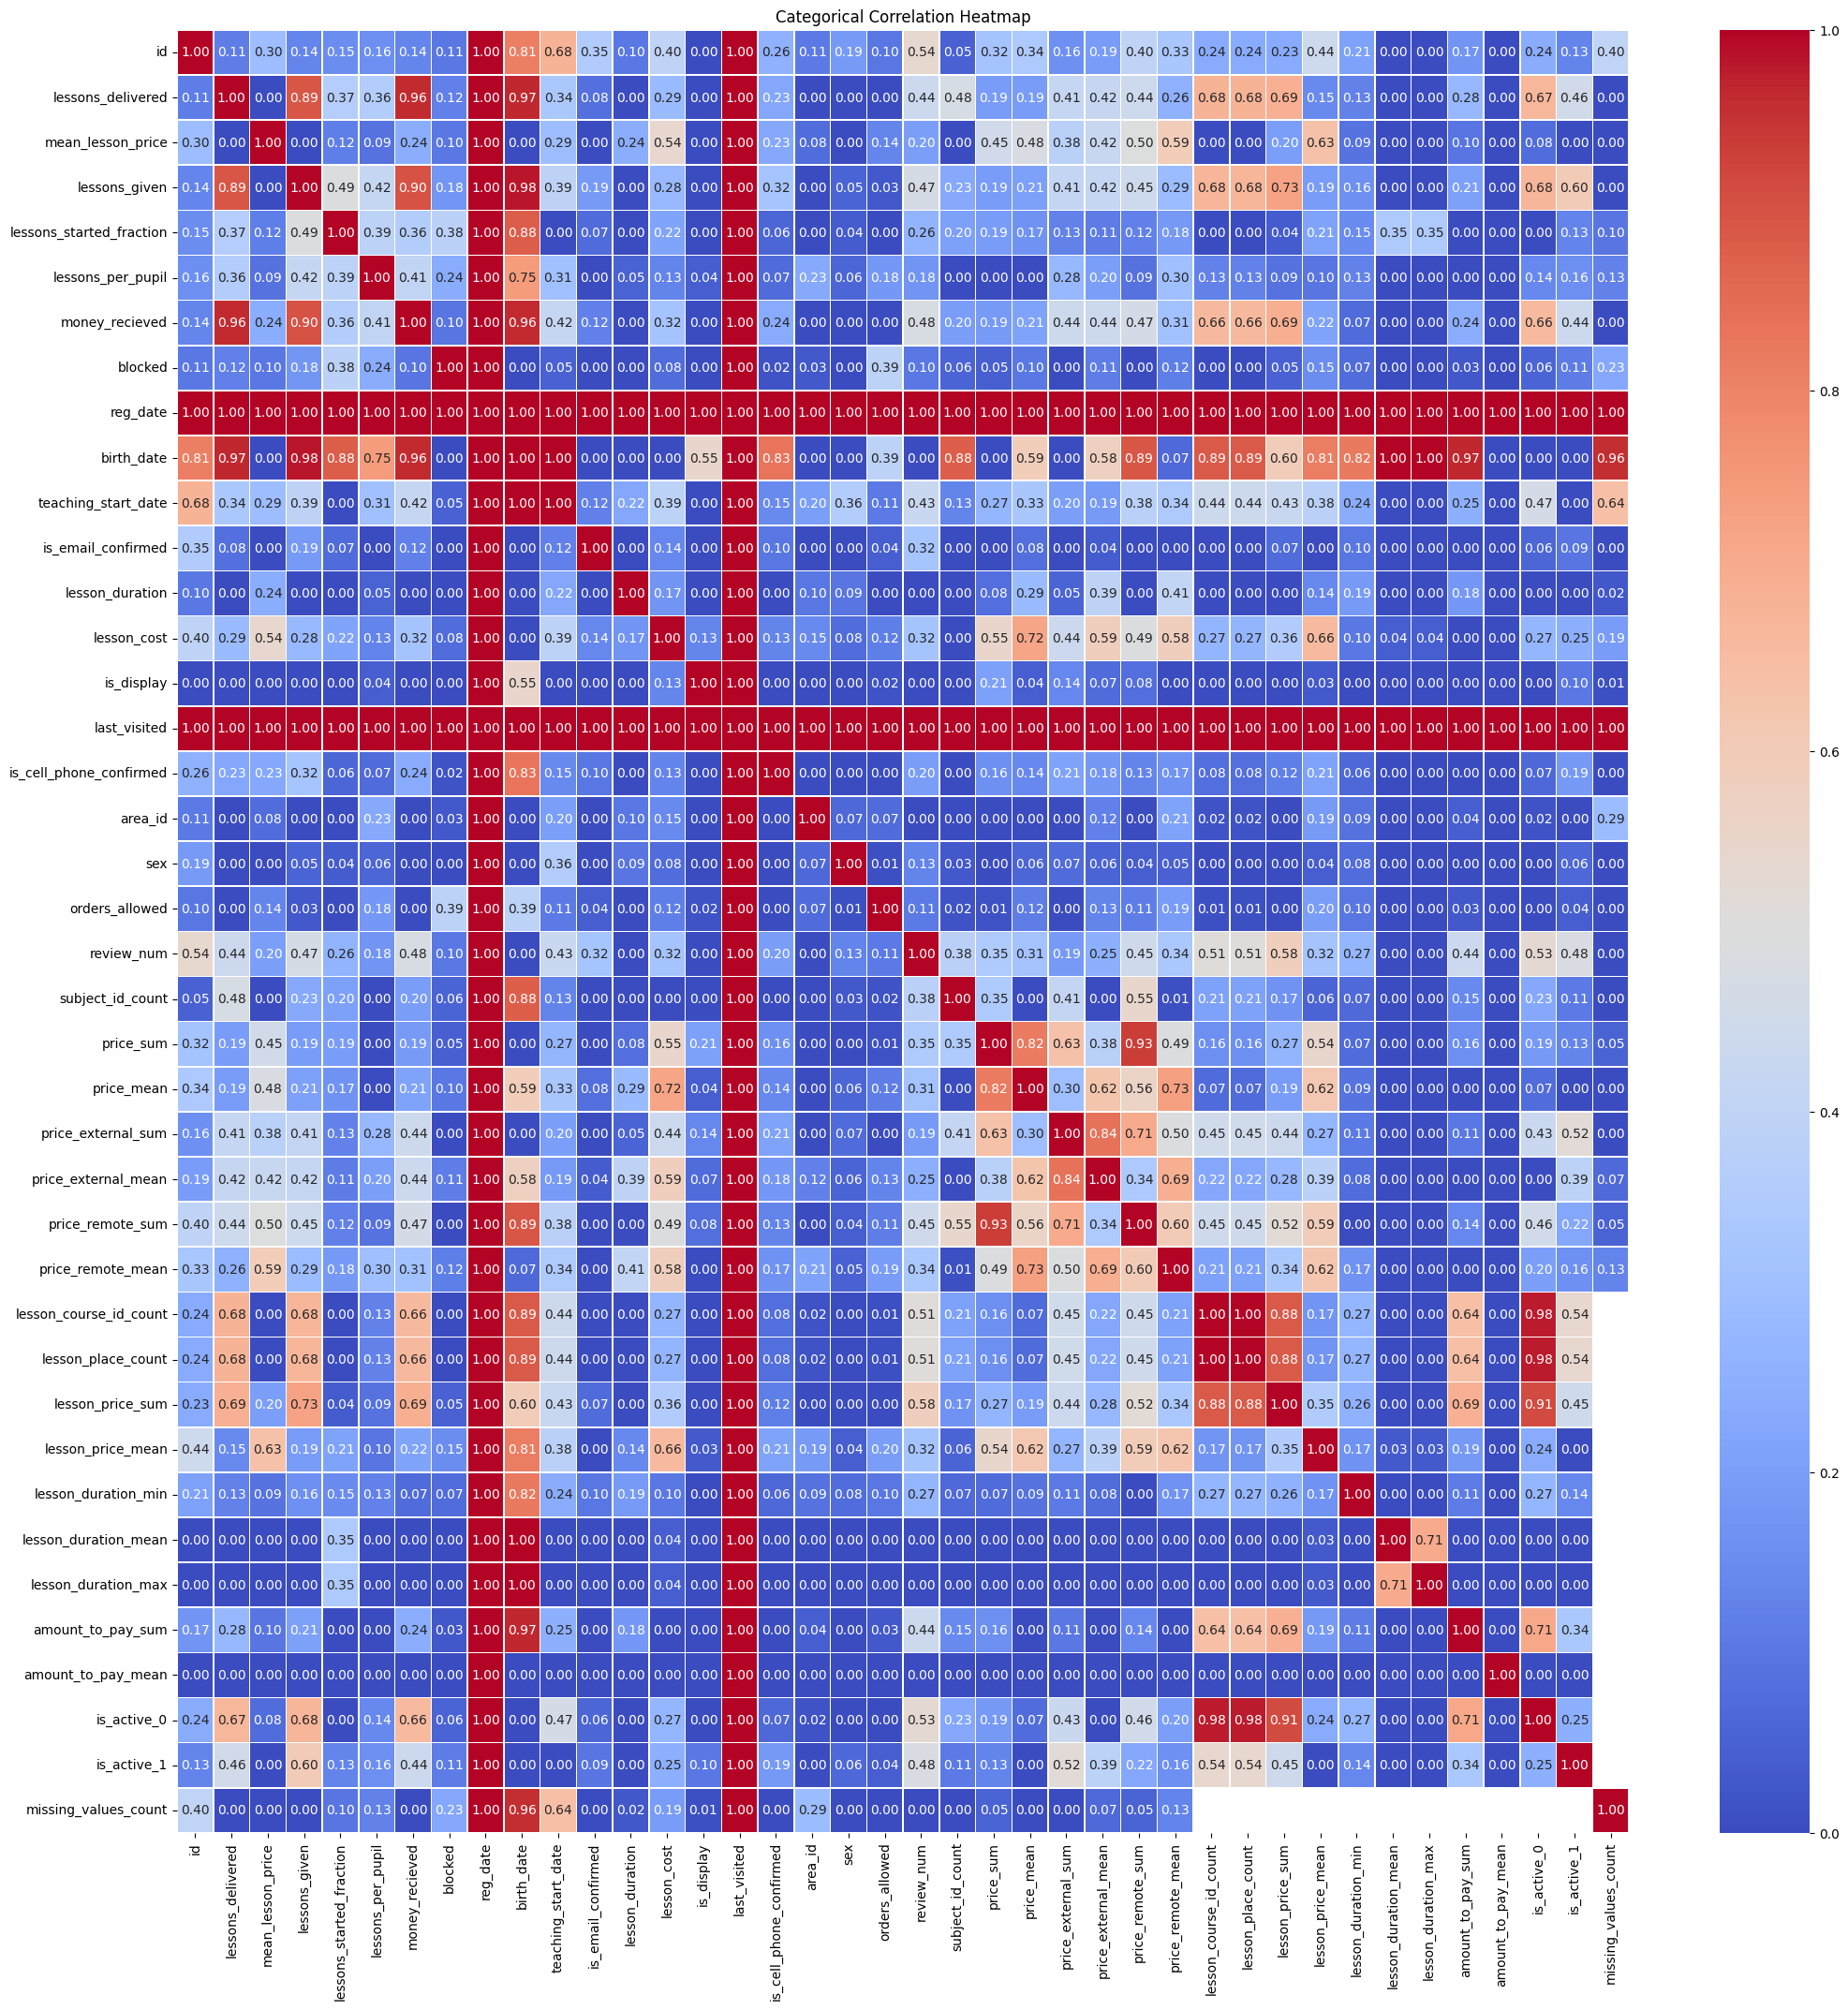

In [581]:
# Расчет таблицы корреляции
corr_df = df.phik_matrix()

plt.figure(
    figsize=(25, 25)
)

# Установка размера шрифта для признаков
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Categorical Correlation Heatmap")
plt.show()

Считаю, следует удалить признаки last_visited и reg_date. Также следует удалить orders_allowed - из-за него происходит утечка + признаки с типом данных datetime

In [582]:
df = df.drop(['last_visited', 'reg_date', 'orders_allowed', 'teaching_start_date', 'teaching_start_date', 'birth_date'], axis=1)

In [583]:
df.head()

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,is_email_confirmed,lesson_duration,lesson_cost,is_display,is_cell_phone_confirmed,area_id,sex,review_num,subject_id_count,price_sum,price_mean,price_external_sum,price_external_mean,price_remote_sum,price_remote_mean,lesson_course_id_count,lesson_place_count,lesson_price_sum,lesson_price_mean,lesson_duration_min,lesson_duration_mean,lesson_duration_max,amount_to_pay_sum,amount_to_pay_mean,is_active_0,is_active_1,missing_values_count
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,0.0,60.0,800.0,1.0,0.0,2.0,1.0,10.0,2,3400,1700.0,0,0.0,3400,1700.0,20.0,20.0,22700.0,1135.000000,60.0,66.000000,90.0,1600.0,1600.000000,15.0,5.0,0
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0,0.0,60.0,600.0,1.0,0.0,13.0,2.0,26.0,1,0,0.0,0,0.0,1200,1200.0,319.0,319.0,284550.0,892.006270,0.0,53.510972,90.0,20500.0,585.714286,310.0,9.0,0
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0,0.0,60.0,2500.0,1.0,0.0,2.0,2.0,64.0,1,0,0.0,0,0.0,2500,2500.0,51.0,51.0,104200.0,2043.137255,0.0,50.000000,90.0,5050.0,1010.000000,46.0,5.0,0
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0,0.0,60.0,1500.0,1.0,0.0,1.0,2.0,10.0,1,2500,2500.0,3000,3000.0,2500,2500.0,82.0,82.0,156300.0,1906.097561,45.0,63.109756,120.0,37100.0,1002.702703,79.0,3.0,0
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0,0.0,45.0,1178.0,1.0,0.0,116.0,2.0,1.0,3,3534,1178.0,0,0.0,3534,1178.0,34.0,34.0,49478.0,1455.235294,45.0,58.676471,60.0,4400.0,1466.666667,27.0,7.0,1


In [584]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1656 entries, 0 to 1655
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1656 non-null   int64  
 1   lessons_delivered         1656 non-null   float64
 2   mean_lesson_price         1656 non-null   float64
 3   lessons_given             1656 non-null   float64
 4   lessons_started_fraction  1656 non-null   float64
 5   lessons_per_pupil         1656 non-null   float64
 6   money_recieved            1656 non-null   float64
 7   blocked                   1656 non-null   int64  
 8   is_email_confirmed        1602 non-null   float64
 9   lesson_duration           1602 non-null   float64
 10  lesson_cost               1602 non-null   float64
 11  is_display                1602 non-null   float64
 12  is_cell_phone_confirmed   1602 non-null   float64
 13  area_id                   1602 non-null   float64
 14  sex     

In [585]:
df = df.fillna(-1)

## Разделение на обучающую и тестовую выборки

In [586]:
features = df.drop(['blocked'], axis=1)
target = df['blocked']

In [587]:
target.value_counts()

0    1099
1     557
Name: blocked, dtype: int64

In [588]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.25,
    stratify=target,
    random_state=42)

## Обучение модели

In [589]:
catboost_model = CatBoostClassifier(loss_function='Logloss', verbose=25, random_state=42)

param_grid = {
    'iterations': [300],
    'depth': [6, 8],
    'learning_rate': [0.01, 0.05],
}

grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=2, verbose=25)

grid_search.fit(features_train, target_train)

print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_

predictions = best_model.predict(features_test)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2; 1/4] START depth=6, iterations=300, learning_rate=0.01.................
0:	learn: 0.6900275	total: 173ms	remaining: 51.6s
25:	learn: 0.6213554	total: 237ms	remaining: 2.5s
50:	learn: 0.5715451	total: 300ms	remaining: 1.46s
75:	learn: 0.5344564	total: 362ms	remaining: 1.07s
100:	learn: 0.5053810	total: 426ms	remaining: 840ms
125:	learn: 0.4820705	total: 488ms	remaining: 674ms
150:	learn: 0.4614425	total: 555ms	remaining: 547ms
175:	learn: 0.4428370	total: 618ms	remaining: 435ms
200:	learn: 0.4263401	total: 687ms	remaining: 338ms
225:	learn: 0.4118535	total: 748ms	remaining: 245ms
250:	learn: 0.3986169	total: 812ms	remaining: 158ms
275:	learn: 0.3862249	total: 874ms	remaining: 76ms
299:	learn: 0.3741626	total: 935ms	remaining: 0us
[CV 1/2; 1/4] END depth=6, iterations=300, learning_rate=0.01;, score=0.758 total time=   1.1s
[CV 2/2; 1/4] START depth=6, iterations=300, learning_rate=0.01.................
0:	learn: 0.68870

In [592]:
precision = precision_score(target_test, predictions, average='weighted')
recall = recall_score(target_test, predictions, average='weighted')
f1 = f1_score(target_test, predictions, average='weighted')
accuracy = accuracy_score(target_test, predictions)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Precision: 0.7352
Recall: 0.7440
F1 Score: 0.7358
Accuracy: 0.7440


## Важность признаков

In [593]:
feature_importances = best_model.get_feature_importance()
feature_importances_df = pd.DataFrame({'feature': features.columns, 'importance': feature_importances})

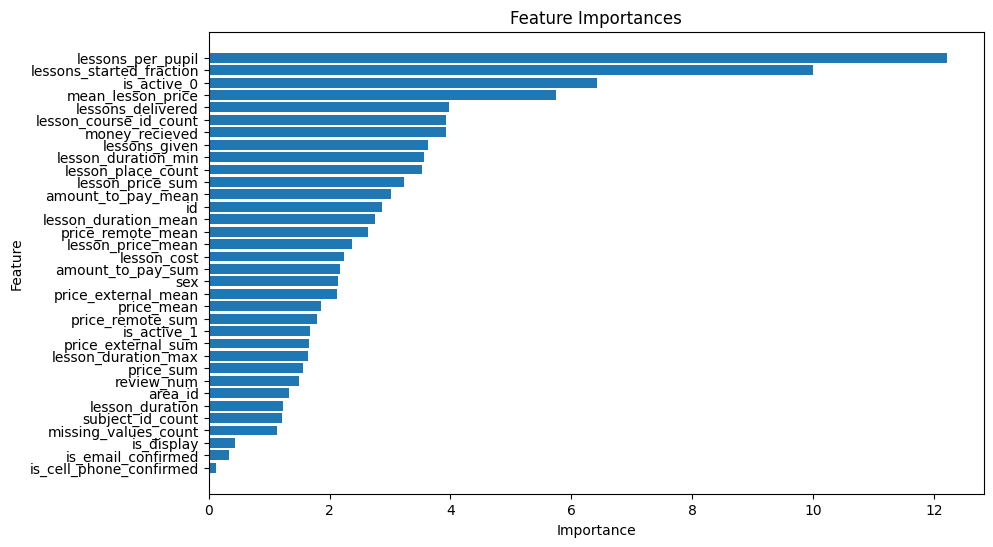

In [599]:
import matplotlib.pyplot as plt
import pandas as pd

# Получение важности признаков
feature_importances = best_model.get_feature_importance()
feature_importances_df = pd.DataFrame({'feature': features.columns, 'importance': feature_importances})

# Сортировка по важности
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

# Создание графика
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['feature'], feature_importances_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Инвертируем ось y для отображения признаков в порядке убывания важности
plt.show()

Топ-3 признака для определения недобросовестности репетиторов:
- `lessons_per_pupil` - занятий на ученика
- `lessons_started_fraction` - процент начала занятий
- `is_active_0` - количество завершенных занятий

Метрики, полученные с помощью CatBoost:
- ''